# EDA of the data
* Performing an EDA of the data to discover preliminary patterns and problems which we will use in our preprocessing of the data

# Importing required libraries

In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, MinMaxScaler
from datetime import datetime
from tqdm.notebook import tqdm #lets us display pretty progress bars for loops
import seaborn as sns

# Setting up display options for pandas

In [316]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Loading the data
* Try to load from pickle file as it is quicker to access
* If this fails, load the original CSV and save it to a pickle file
* <b>No point in doing anything with weather data as we only have 1 years worth of values so it is impossible to leverage with our chosen RNN/CNN based models to predict the next years worth of energy readings</b>
    * <b>Unless we leveraged them to produce multivariate predictions and also predicting the weathers values in order to use those as input for subsequent days: but this will likely result in worse performing energy predictions</b>
* Hence we are only looking into addInfo and consumption

In [317]:
#try to load pickle file as it is quicker
try:
    print("Loading consumption via pickle")
    df_energy = pd.read_pickle("../Data/Original_Data/consumption.pkl")
# if the file was not found then load the csv then save it to pickle for future loads
except:
    print("Loading consumption via csv")
    df_energy = pd.read_csv("../Data/Original_Data/consumption.csv")
    df_energy.to_pickle("../Data/Original_Data/consumption.pkl")

    #try to load pickle file as it is quicker
try:
    print("Loading addInfo via pickle")
    df_info = pd.read_pickle("../Data/Original_Data/addInfo.pkl")
# if the file was not found then load the csv then save it to pickle for future loads
except:
    print("Loading addInfo via csv")
    df_info = pd.read_csv("../Data/Original_Data/addInfo.csv")
    df_info.to_pickle("../Data/Original_Data/addInfo.pkl")

Loading consumption via pickle
Loading addInfo via pickle


# Inspecting df_energy and df_info

In [318]:
# inspecting the values of the dataframe
df_energy

,meter_id,2017-01-01 00:00:00,2017-01-01 00:30:00,2017-01-01 01:00:00,2017-01-01 01:30:00,2017-01-01 02:00:00,2017-01-01 02:30:00,2017-01-01 03:00:00,2017-01-01 03:30:00,2017-01-01 04:00:00,2017-01-01 04:30:00,2017-01-01 05:00:00,2017-01-01 05:30:00,2017-01-01 06:00:00,2017-01-01 06:30:00,2017-01-01 07:00:00,2017-01-01 07:30:00,2017-01-01 08:00:00,2017-01-01 08:30:00,2017-01-01 09:00:00,2017-01-01 09:30:00,2017-01-01 10:00:00,2017-01-01 10:30:00,2017-01-01 11:00:00,2017-01-01 11:30:00,2017-01-01 12:00:00,2017-01-01 12:30:00,2017-01-01 13:00:00,2017-01-01 13:30:00,2017-01-01 14:00:00,2017-01-01 14:30:00,2017-01-01 15:00:00,2017-01-01 15:30:00,2017-01-01 16:00:00,2017-01-01 16:30:00,2017-01-01 17:00:00,2017-01-01 17:30:00,2017-01-01 18:00:00,2017-01-01 18:30:00,2017-01-01 19:00:00,2017-01-01 19:30:00,2017-01-01 20:00:00,2017-01-01 20:30:00,2017-01-01 21:00:00,2017-01-01 21:30:00,2017-01-01 22:00:00,2017-01-01 22:30:00,2017-01-01 23:00:00,2017-01-01 23:30:00,2017-01-02 00:00:00,2017-01-02 00:30:00,2017-01-02 01:00:00,2017-01-02 01:30:00,2017-01-02 02:00:00,2017-01-02 02:30:00,2017-01-02 03:00:00,2017-01-02 03:30:00,2017-01-02 04:00:00,2017-01-02 04:30:00,2017-01-02 05:00:00,2017-01-02 05:30:00,2017-01-02 06:00:00,2017-01-02 06:30:00,2017-01-02 07:00:00,2017-01-02 07:30:00,2017-01-02 08:00:00,2017-01-02 08:30:00,2017-01-02 09:00:00,2017-01-02 09:30:00,2017-01-02 10:00:00,2017-01-02 10:30:00,2017-01-02 11:00:00,2017-01-02 11:30:00,2017-01-02 12:00:00,2017-01-02 12:30:00,2017-01-02 13:00:00,2017-01-02 13:30:00,2017-01-02 14:00:00,2017-01-02 14:30:00,2017-01-02 15:00:00,2017-01-02 15:30:00,2017-01-02 16:00:00,2017-01-02 16:30:00,2017-01-02 17:00:00,2017-01-02 17:30:00,2017-01-02 18:00:00,2017-01-02 18:30:00,2017-01-02 19:00:00,2017-01-02 19:30:00,2017-01-02 20:00:00,2017-01-02 20:30:00,2017-01-02 21:00:00,2017-01-02 21:30:00,2017-01-02 22:00:00,2017-01-02 22:30:00,2017-01-02 23:00:00,2017-01-02 23:30:00,2017-01-03 00:00:00,2017-01-03 00:30:00,2017-01-03 01:00:00,2017-01-03 01:30:00,2017-01-03 02:00:00,2017-01-03 02:30:00,2017-01-03 03:00:00,2017-01-03 03:30:00,2017-01-03 04:00:00,2017-01-03 04:30:00,2017-01-03 05:00:00,2017-01-03 05:30:00,2017-01-03 06:00:00,2017-01-03 06:30:00,2017-01-03 07:00:00,2017-01-03 07:30:00,2017-01-03 08:00:00,2017-01-03 08:30:00,2017-01-03 09:00:00,2017-01-03 09:30:00,2017-01-03 10:00:00,2017-01-03 10:30:00,2017-01-03 11:00:00,2017-01-03 11:30:00,2017-01-03 12:00:00,2017-01-03 12:30:00,2017-01-03 13:00:00,2017-01-03 13:30:00,2017-01-03 14:00:00,2017-01-03 14:30:00,2017-01-03 15:00:00,2017-01-03 15:30:00,2017-01-03 16:00:00,2017-01-03 16:30:00,2017-01-03 17:00:00,2017-01-03 17:30:00,2017-01-03 18:00:00,2017-01-03 18:30:00,2017-01-03 19:00:00,2017-01-03 19:30:00,2017-01-03 20:00:00,2017-01-03 20:30:00,2017-01-03 21:00:00,2017-01-03 21:30:00,2017-01-03 22:00:00,2017-01-03 22:30:00,2017-01-03 23:00:00,2017-01-03 23:30:00,2017-01-04 00:00:00,2017-01-04 00:30:00,2017-01-04 01:00:00,2017-01-04 01:30:00,2017-01-04 02:00:00,2017-01-04 02:30:00,2017-01-04 03:00:00,2017-01-04 03:30:00,2017-01-04 04:00:00,2017-01-04 04:30:00,2017-01-04 05:00:00,2017-01-04 05:30:00,2017-01-04 06:00:00,2017-01-04 06:30:00,2017-01-04 07:00:00,2017-01-04 07:30:00,2017-01-04 08:00:00,2017-01-04 08:30:00,2017-01-04 09:00:00,2017-01-04 09:30:00,2017-01-04 10:00:00,2017-01-04 10:30:00,2017-01-04 11:00:00,2017-01-04 11:30:00,2017-01-04 12:00:00,2017-01-04 12:30:00,2017-01-04 13:00:00,2017-01-04 13:30:00,2017-01-04 14:00:00,2017-01-04 14:30:00,2017-01-04 15:00:00,2017-01-04 15:30:00,2017-01-04 16:00:00,2017-01-04 16:30:00,2017-01-04 17:00:00,2017-01-04 17:30:00,2017-01-04 18:00:00,2017-01-04 18:30:00,2017-01-04 19:00:00,2017-01-04 19:30:00,2017-01-04 20:00:00,2017-01-04 20:30:00,2017-01-04 21:00:00,2017-01-04 21:30:00,2017-01-04 22:00:00,2017-01-04 22:30:00,2017-01-04 23:00:00,2017-01-04 23:30:00,2017-01-05 00:00:00,2017-01-05 00:30:00,2017-01-05 01:00:00,2017-01-05 01:30:00,2017-01-05 02:00:00,2017-01-05 02:30:00,2017-01-05 03:00:00,2017-01-05

In [319]:
# inspecting the shape of the dataframe
df_energy.shape

(3248, 17521)

In [320]:
# inspecting the values of the dataframe
df_info

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,terraced_house,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,semi_detached_house,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,0xb9c600842cb2d195d461d675f2758ddbf5bb45bb,terraced_house,2.0,2.0,gas,gas,old,y,n,18_to_20,75_to_100,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0
2139,0x429e76a41f3141d9e62c4975e6b5df303cb45e64,bungalow,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2140,0x65fbd9ba598e703d742a32058ea2b323fe4c1fca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2141,0x101f2dc409b3b95d2bb08ebe5d282f54317e3f8c,bungalow,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [321]:
# inspecting the shape of the dataframe
df_info.shape

(2143, 24)

#### Conclusions to be drawn

* Can see that df_info only has entries for 2140 of the 3248 possible rows
* Must add the missing rows filled with NaN

# EDA on consumption

In [322]:
# how many missing values?
print(df_energy.isnull().sum().sum())

29378388


##### Conclusions:
* Large number of missing values hence we must find a way to deal with that
    * Will experiment with:
        1. Imputing the missing values linearly
        2. Dropping the missing values entirely and only using values we do have
        3. just treating missing values as 0

## Resampling from 30 min intervals into days 
* Resmapling into days as it'll be better suited for our RNN based models to learn from

In [323]:
# function for resampling into day
def resample_to_day(df_energy, file_name):
    #resampling into day giving us the total energy for that day (this will be what we use to learn)
    meter_id = df_energy["meter_id"]
    df_energy_day = pd.DataFrame(columns=["meter_id"])
    df_energy_day["meter_id"] = meter_id

    #for each day in the range of dates
    for day_i in tqdm(pd.date_range(datetime(2017, 1, 1), datetime(2017, 12, 31), freq = "D")):
        #get this days name as a string
        dayname = str(day_i.date())
        #get all columns that relate to this day
        col_day_i = [i for i in df_energy.columns.values[1:] if i.startswith(dayname)]
        #sum these up into a daily value
        df_energy_day[dayname] = df_energy[col_day_i].sum(axis=1)
    
    #saving the dataframe
    if(os.path.exists(f"../Data/Preprocessed_Data/{file_name}.pkl")==False):
        df_energy_day.to_pickle(f"../Data/Preprocessed_Data/{file_name}.pkl")
        
    return df_energy_day

In [324]:
# resampling the original data into a daily value
df_energy_daily = resample_to_day(df_energy, "consumption_daily")

  0%|          | 0/365 [00:00<?, ?it/s]

In [325]:
df_energy_daily

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-22,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-04,2017-02-05,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-18,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-21,2017-10-22,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-17,2017-11-18,2017-11-19,2017-11-20,2017-11-21,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-

## Linearly interpolating the missing values

In [326]:
#dropping the meter id column for now so we can interpolate
meter_id = df_energy["meter_id"]
df_energy_interpolate = df_energy_daily.drop(["meter_id"], axis=1)

In [327]:
#replacing 0 back to NaN
df_energy_interpolate=df_energy_interpolate.replace(0,np.nan)

In [328]:
# interpolating the missing values
df_energy_interpolate = df_energy_interpolate.interpolate(method="linear", axis=1)
# adding the meter id back on
df_energy_interpolate = pd.concat([meter_id,df_energy_interpolate],axis=1)

In [329]:
#inspecting state of data now (example: look around 2017-12-24 , 20:00:00)
df_energy_interpolate

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-22,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-04,2017-02-05,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-18,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-21,2017-10-22,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-17,2017-11-18,2017-11-19,2017-11-20,2017-11-21,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-

In [330]:
# saving the dataframe
if(os.path.exists(f"../Data/Preprocessed_Data/consumption_daily_interpolated.pkl")==False):
        df_energy_interpolate.to_pickle(f"../Data/Preprocessed_Data/consumption_daily_interpolated.pkl")

## Plotting graph of the time patterns for each meter TODO

#### Conclusions:
* Have removed the missing values that could be removed via linear interpolation:
    * when there are values before and after the sequence of ?
* Still have lots of missing values at start and end of dataset

As can be seen we have now added the missing rows to df_info

# EDA on AddInfo
## Adding missing rows to AddInfo based on missing meter_id's

In [331]:
# first making both dataframes alphabetical in order of meter_id for ease of comparison
df_info.sort_values('meter_id')

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
750,0x000f697092696c27b0bb489ea4c11280ef72ab82,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,0x001d6227832325ab6167b82d6d7175d254f57c3a,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643,0x005958406351bb29580475df698b5f1070096397,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
694,0x00735e1aa83d97d9209cce47d8777b4ff3cc0554,terraced_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2056,0x0079fa6c2cbd3de97c8aa6073ff365b41ee087ab,terraced_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1463,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1685,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
df_energy.sort_values('meter_id')

,meter_id,2017-01-01 00:00:00,2017-01-01 00:30:00,2017-01-01 01:00:00,2017-01-01 01:30:00,2017-01-01 02:00:00,2017-01-01 02:30:00,2017-01-01 03:00:00,2017-01-01 03:30:00,2017-01-01 04:00:00,2017-01-01 04:30:00,2017-01-01 05:00:00,2017-01-01 05:30:00,2017-01-01 06:00:00,2017-01-01 06:30:00,2017-01-01 07:00:00,2017-01-01 07:30:00,2017-01-01 08:00:00,2017-01-01 08:30:00,2017-01-01 09:00:00,2017-01-01 09:30:00,2017-01-01 10:00:00,2017-01-01 10:30:00,2017-01-01 11:00:00,2017-01-01 11:30:00,2017-01-01 12:00:00,2017-01-01 12:30:00,2017-01-01 13:00:00,2017-01-01 13:30:00,2017-01-01 14:00:00,2017-01-01 14:30:00,2017-01-01 15:00:00,2017-01-01 15:30:00,2017-01-01 16:00:00,2017-01-01 16:30:00,2017-01-01 17:00:00,2017-01-01 17:30:00,2017-01-01 18:00:00,2017-01-01 18:30:00,2017-01-01 19:00:00,2017-01-01 19:30:00,2017-01-01 20:00:00,2017-01-01 20:30:00,2017-01-01 21:00:00,2017-01-01 21:30:00,2017-01-01 22:00:00,2017-01-01 22:30:00,2017-01-01 23:00:00,2017-01-01 23:30:00,2017-01-02 00:00:00,2017-01-02 00:30:00,2017-01-02 01:00:00,2017-01-02 01:30:00,2017-01-02 02:00:00,2017-01-02 02:30:00,2017-01-02 03:00:00,2017-01-02 03:30:00,2017-01-02 04:00:00,2017-01-02 04:30:00,2017-01-02 05:00:00,2017-01-02 05:30:00,2017-01-02 06:00:00,2017-01-02 06:30:00,2017-01-02 07:00:00,2017-01-02 07:30:00,2017-01-02 08:00:00,2017-01-02 08:30:00,2017-01-02 09:00:00,2017-01-02 09:30:00,2017-01-02 10:00:00,2017-01-02 10:30:00,2017-01-02 11:00:00,2017-01-02 11:30:00,2017-01-02 12:00:00,2017-01-02 12:30:00,2017-01-02 13:00:00,2017-01-02 13:30:00,2017-01-02 14:00:00,2017-01-02 14:30:00,2017-01-02 15:00:00,2017-01-02 15:30:00,2017-01-02 16:00:00,2017-01-02 16:30:00,2017-01-02 17:00:00,2017-01-02 17:30:00,2017-01-02 18:00:00,2017-01-02 18:30:00,2017-01-02 19:00:00,2017-01-02 19:30:00,2017-01-02 20:00:00,2017-01-02 20:30:00,2017-01-02 21:00:00,2017-01-02 21:30:00,2017-01-02 22:00:00,2017-01-02 22:30:00,2017-01-02 23:00:00,2017-01-02 23:30:00,2017-01-03 00:00:00,2017-01-03 00:30:00,2017-01-03 01:00:00,2017-01-03 01:30:00,2017-01-03 02:00:00,2017-01-03 02:30:00,2017-01-03 03:00:00,2017-01-03 03:30:00,2017-01-03 04:00:00,2017-01-03 04:30:00,2017-01-03 05:00:00,2017-01-03 05:30:00,2017-01-03 06:00:00,2017-01-03 06:30:00,2017-01-03 07:00:00,2017-01-03 07:30:00,2017-01-03 08:00:00,2017-01-03 08:30:00,2017-01-03 09:00:00,2017-01-03 09:30:00,2017-01-03 10:00:00,2017-01-03 10:30:00,2017-01-03 11:00:00,2017-01-03 11:30:00,2017-01-03 12:00:00,2017-01-03 12:30:00,2017-01-03 13:00:00,2017-01-03 13:30:00,2017-01-03 14:00:00,2017-01-03 14:30:00,2017-01-03 15:00:00,2017-01-03 15:30:00,2017-01-03 16:00:00,2017-01-03 16:30:00,2017-01-03 17:00:00,2017-01-03 17:30:00,2017-01-03 18:00:00,2017-01-03 18:30:00,2017-01-03 19:00:00,2017-01-03 19:30:00,2017-01-03 20:00:00,2017-01-03 20:30:00,2017-01-03 21:00:00,2017-01-03 21:30:00,2017-01-03 22:00:00,2017-01-03 22:30:00,2017-01-03 23:00:00,2017-01-03 23:30:00,2017-01-04 00:00:00,2017-01-04 00:30:00,2017-01-04 01:00:00,2017-01-04 01:30:00,2017-01-04 02:00:00,2017-01-04 02:30:00,2017-01-04 03:00:00,2017-01-04 03:30:00,2017-01-04 04:00:00,2017-01-04 04:30:00,2017-01-04 05:00:00,2017-01-04 05:30:00,2017-01-04 06:00:00,2017-01-04 06:30:00,2017-01-04 07:00:00,2017-01-04 07:30:00,2017-01-04 08:00:00,2017-01-04 08:30:00,2017-01-04 09:00:00,2017-01-04 09:30:00,2017-01-04 10:00:00,2017-01-04 10:30:00,2017-01-04 11:00:00,2017-01-04 11:30:00,2017-01-04 12:00:00,2017-01-04 12:30:00,2017-01-04 13:00:00,2017-01-04 13:30:00,2017-01-04 14:00:00,2017-01-04 14:30:00,2017-01-04 15:00:00,2017-01-04 15:30:00,2017-01-04 16:00:00,2017-01-04 16:30:00,2017-01-04 17:00:00,2017-01-04 17:30:00,2017-01-04 18:00:00,2017-01-04 18:30:00,2017-01-04 19:00:00,2017-01-04 19:30:00,2017-01-04 20:00:00,2017-01-04 20:30:00,2017-01-04 21:00:00,2017-01-04 21:30:00,2017-01-04 22:00:00,2017-01-04 22:30:00,2017-01-04 23:00:00,2017-01-04 23:30:00,2017-01-05 00:00:00,2017-01-05 00:30:00,2017-01-05 01:00:00,2017-01-05 01:30:00,2017-01-05 02:00:00,2017-01-05 02:30:00,2017-01-05 03:00:00,2017-01-05

In [333]:
#adding the missing meter rows to df_info
df_info_all_meters = pd.merge(df_info, df_energy["meter_id"], on="meter_id",how="outer")

In [334]:
#checking the values are correct now
df_info_all_meters.sort_values('meter_id')

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
2532,0x0001f1c389823f953b2eaee0a61c33539744da0c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
750,0x000f697092696c27b0bb489ea4c11280ef72ab82,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2468,0x0019979ee12c59accd24d1c83291528ced1bb734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,0x001d6227832325ab6167b82d6d7175d254f57c3a,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643,0x005958406351bb29580475df698b5f1070096397,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1463,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1685,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [335]:
#checking the shape is correct now
df_info_all_meters.shape

(3248, 24)

## Exploring datatypes and unique values

In [336]:
# inspecting the types of each column
df_info_all_meters.dtypes

meter_id                          object
dwelling_type                     object
num_occupants                    float64
num_bedrooms                     float64
heating_fuel                      object
hot_water_fuel                    object
boiler_age                        object
loft_insulation                   object
wall_insulation                   object
heating_temperature               object
efficient_lighting_percentage     object
dishwasher                       float64
freezer                          float64
fridge_freezer                   float64
refrigerator                     float64
tumble_dryer                     float64
washing_machine                  float64
game_console                     float64
laptop                           float64
pc                               float64
router                           float64
set_top_box                      float64
tablet                           float64
tv                               float64
dtype: object

In [337]:
#looking at the unique values for each column
for column in df_info_all_meters.drop(["meter_id"],axis=1).columns:
    print(column+" unique value count: "+str(df_info_all_meters[column].nunique()))
    print(df_info_all_meters[column].unique())
    print()

dwelling_type unique value count: 5
['semi_detached_house' 'terraced_house' 'detached_house' nan 'bungalow'
 'flat']

num_occupants unique value count: 4
[nan  2.  4.  3.  1.]

num_bedrooms unique value count: 5
[ 3.  2. nan  4.  5.  1.]

heating_fuel unique value count: 4
[nan 'gas' 'elec' 'other' 'lpg_oil']

hot_water_fuel unique value count: 3
[nan 'gas' 'elec' 'other']

boiler_age unique value count: 2
[nan 'new' 'old']

loft_insulation unique value count: 2
[nan 'y' 'n']

wall_insulation unique value count: 5
[nan 'y_cavity' 'n' 'y_internal' 'not_sure' 'y_external']

heating_temperature unique value count: 4
[nan '18_to_20' 'above_20' 'below_18' 'not_sure']

efficient_lighting_percentage unique value count: 4
[nan '0_to_25' '25_to_50' '50_to_75' '75_to_100']

dishwasher unique value count: 3
[nan  1.  0.  2.]

freezer unique value count: 3
[nan  2.  1.  0.]

fridge_freezer unique value count: 3
[nan  2.  0.  1.]

refrigerator unique value count: 3
[nan  2.  1.  0.]

tumble_dryer u

* We now know:
    1. The columns that contain categorical values vs the columns that contain real numbers
    2. The unique values for each column
    
## Exploring missing values
### Visualising as histogram

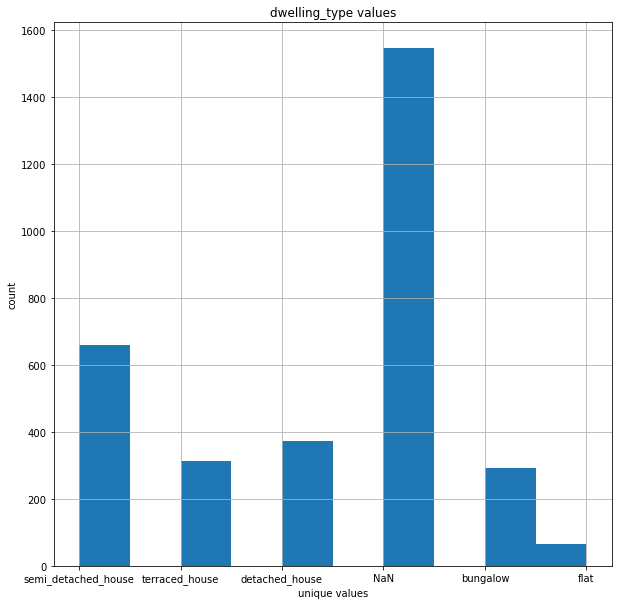

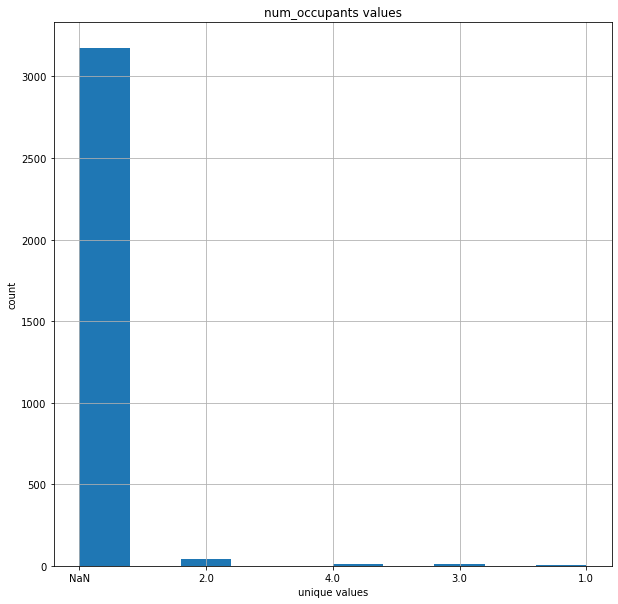

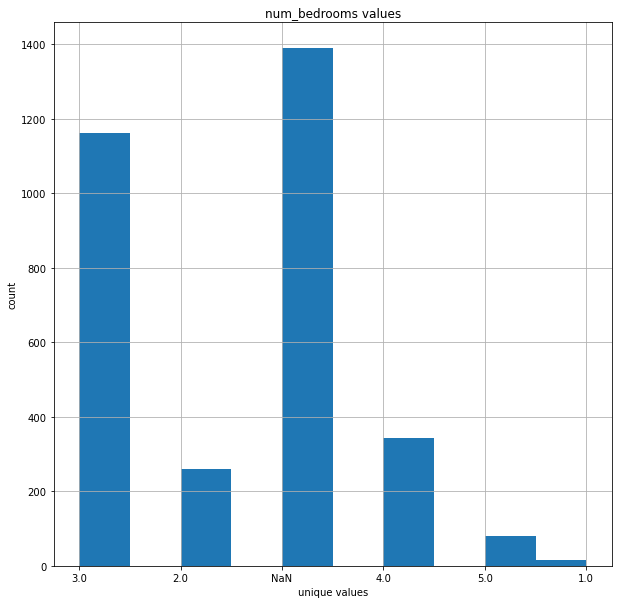

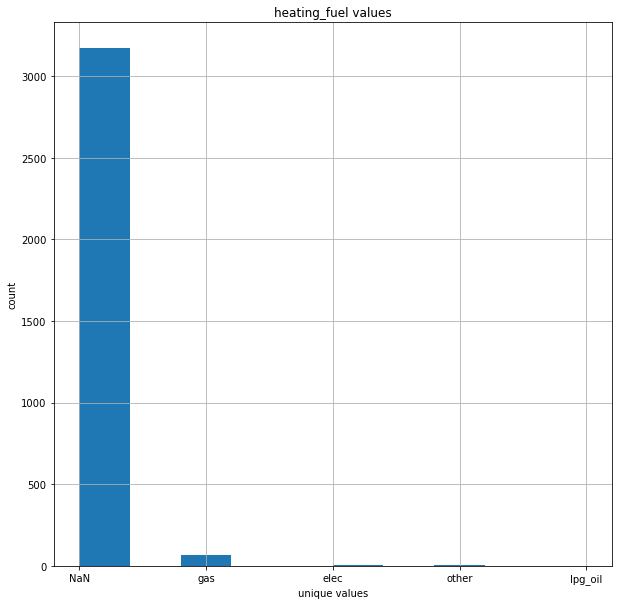

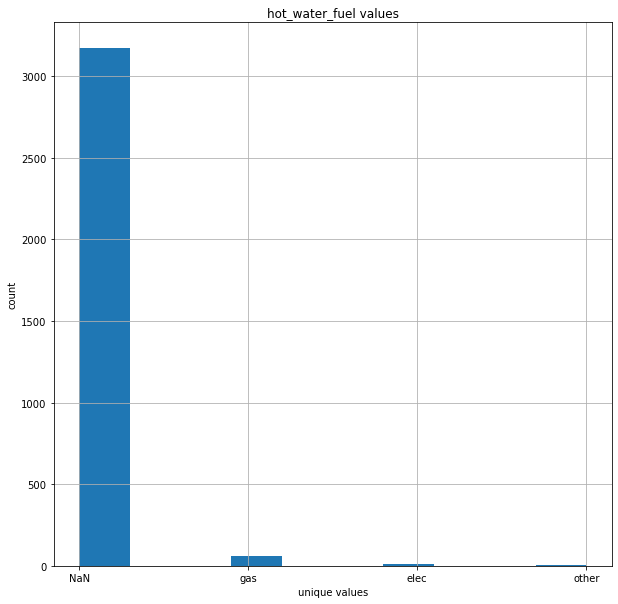

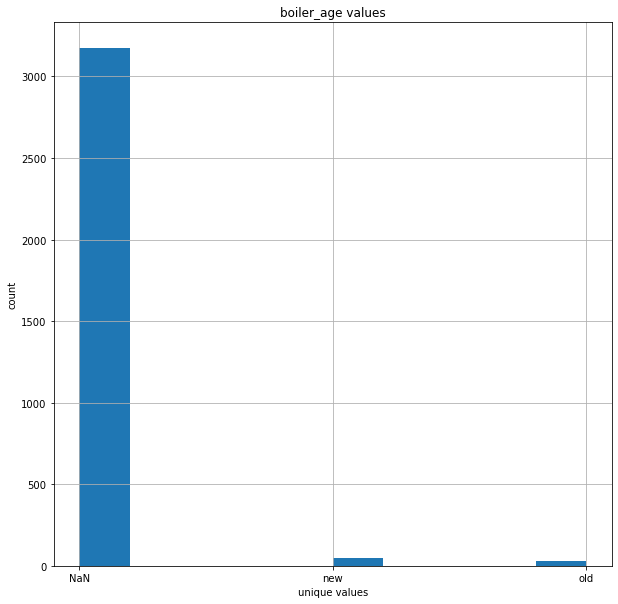

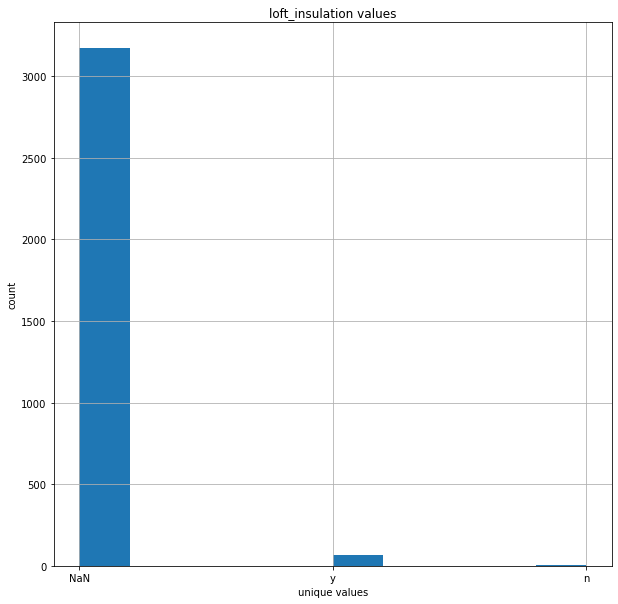

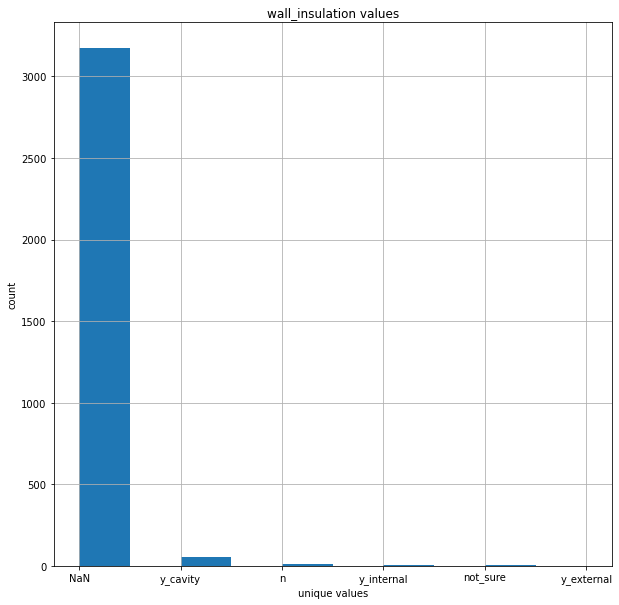

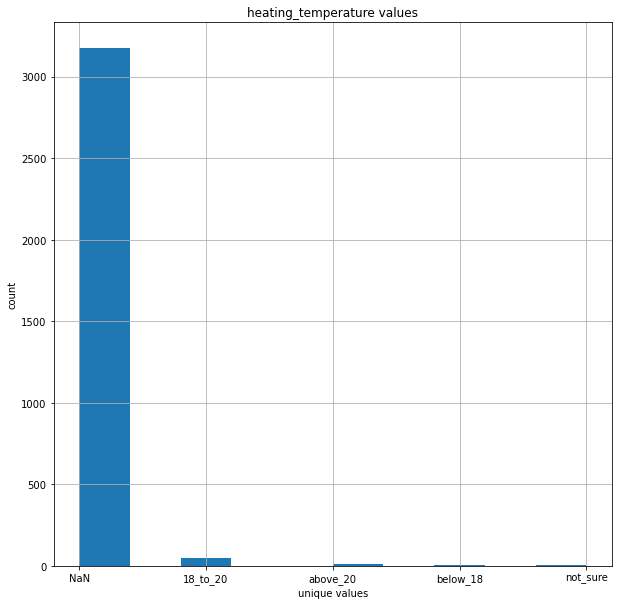

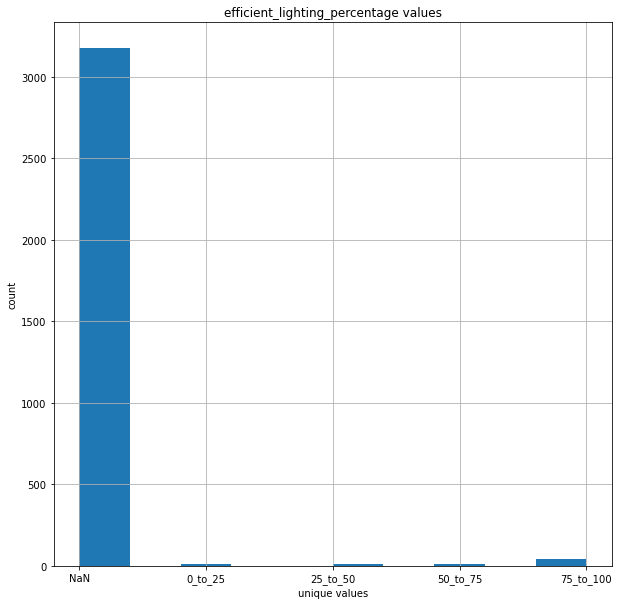

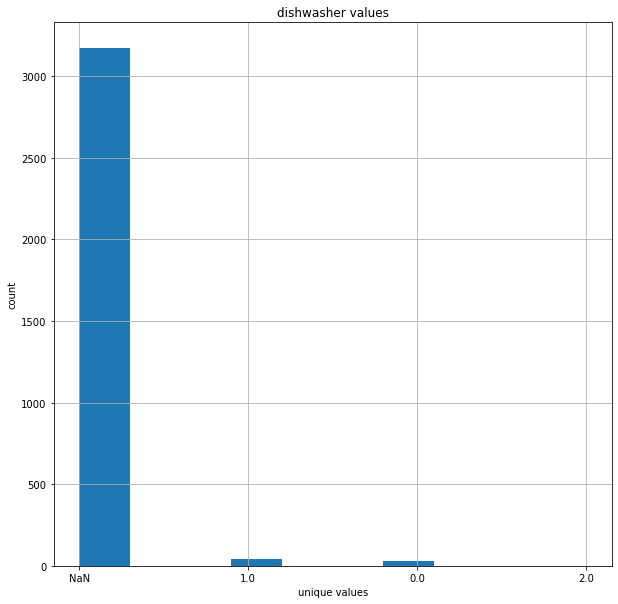

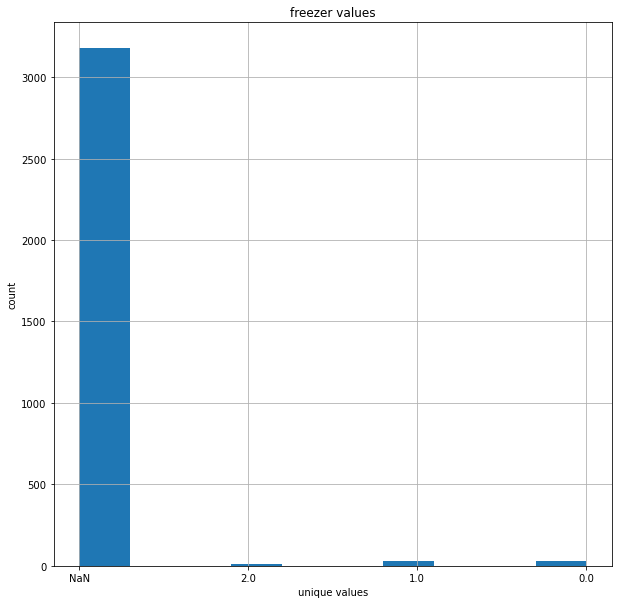

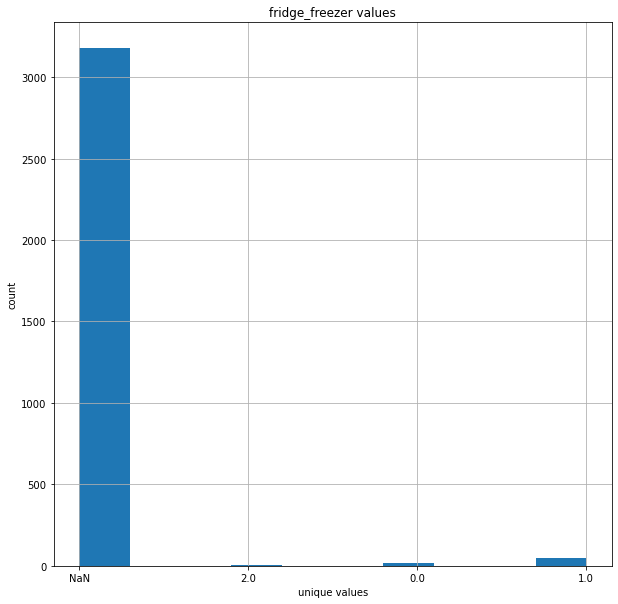

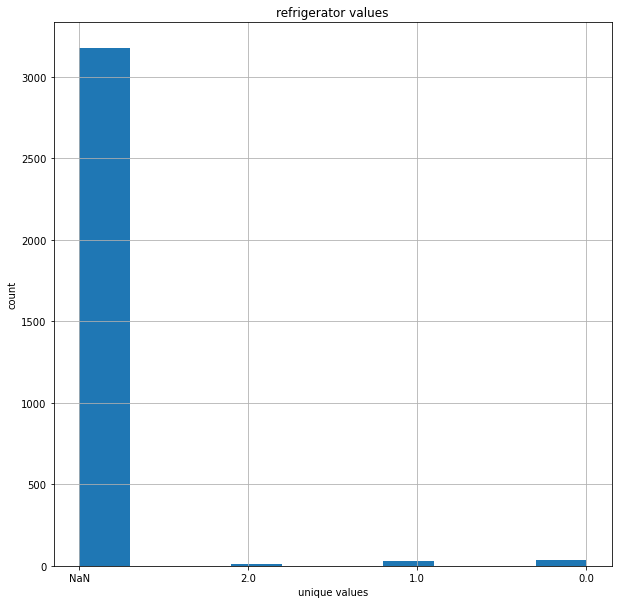

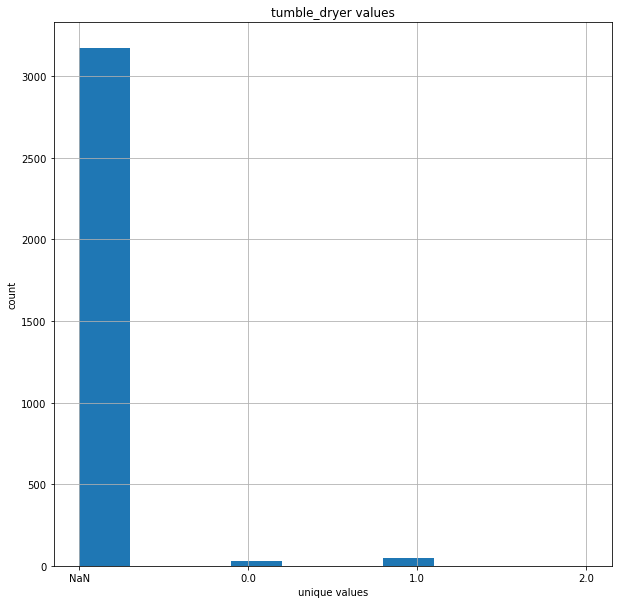

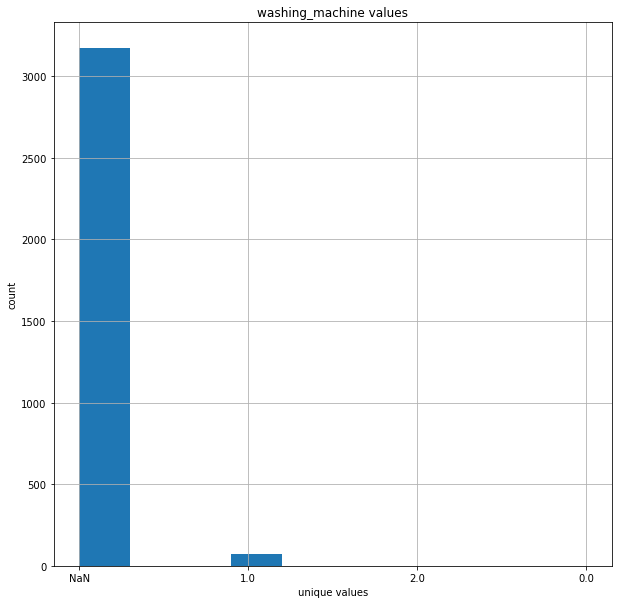

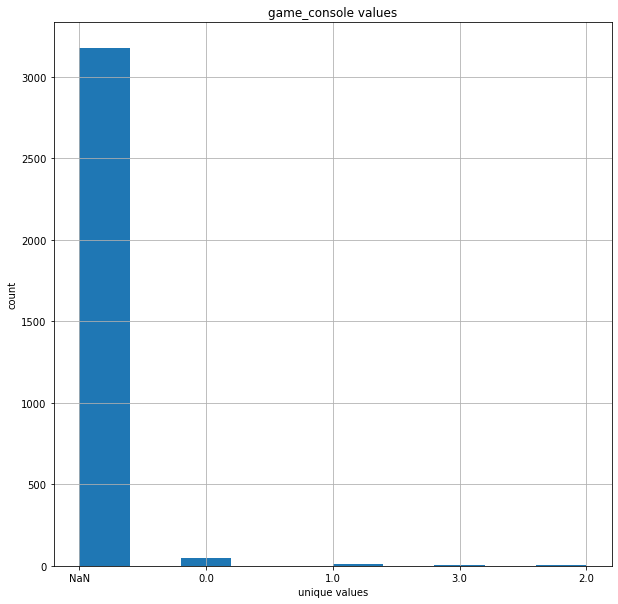

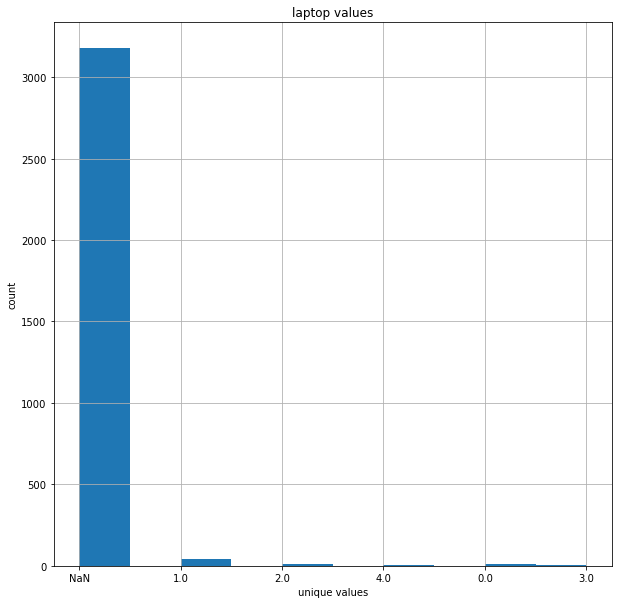

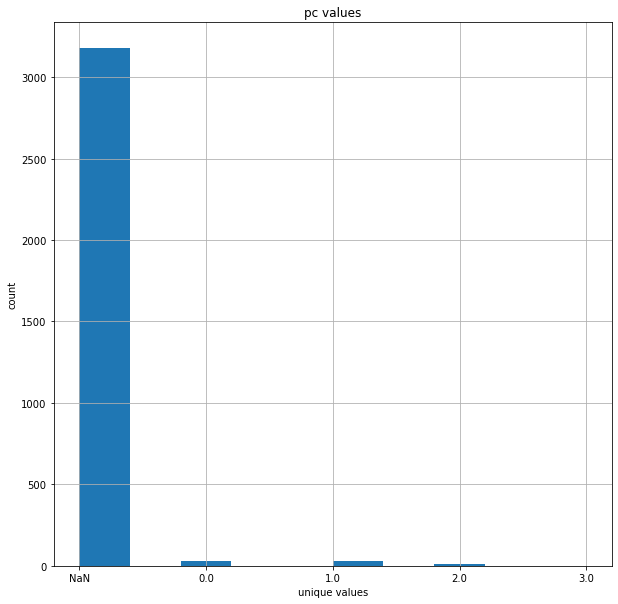

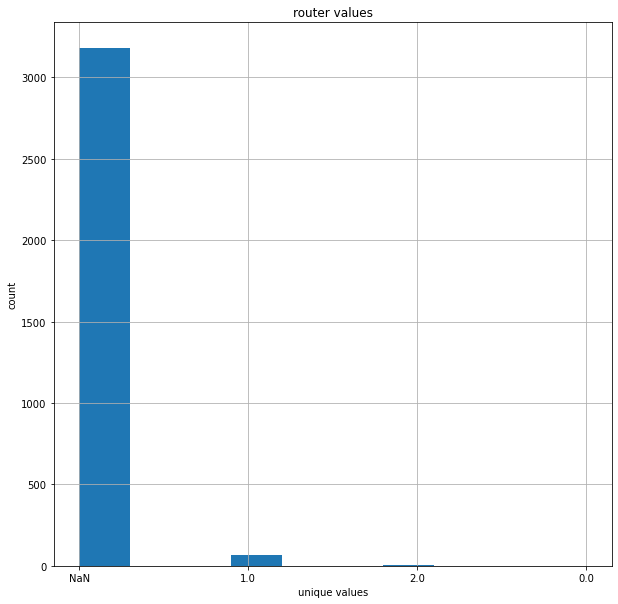

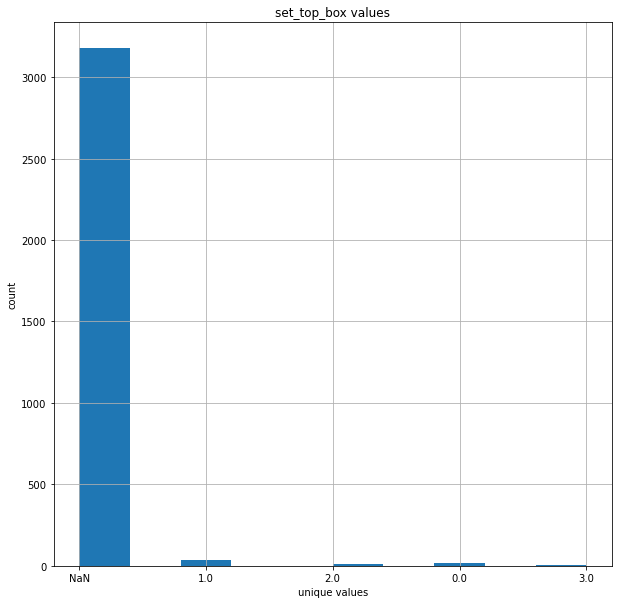

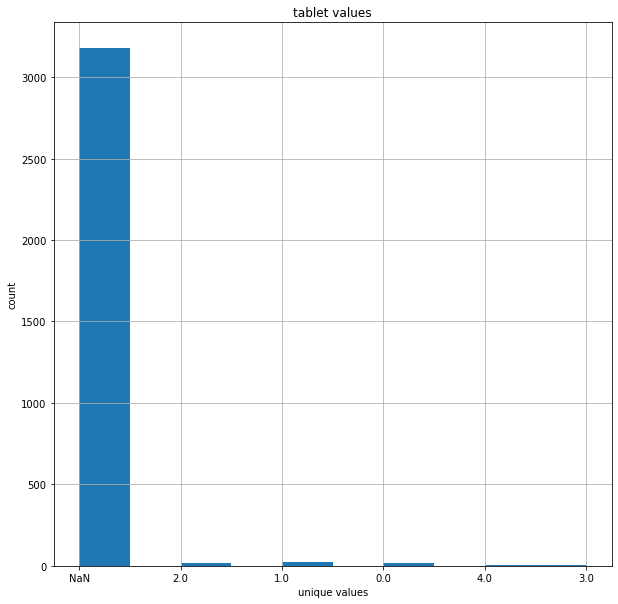

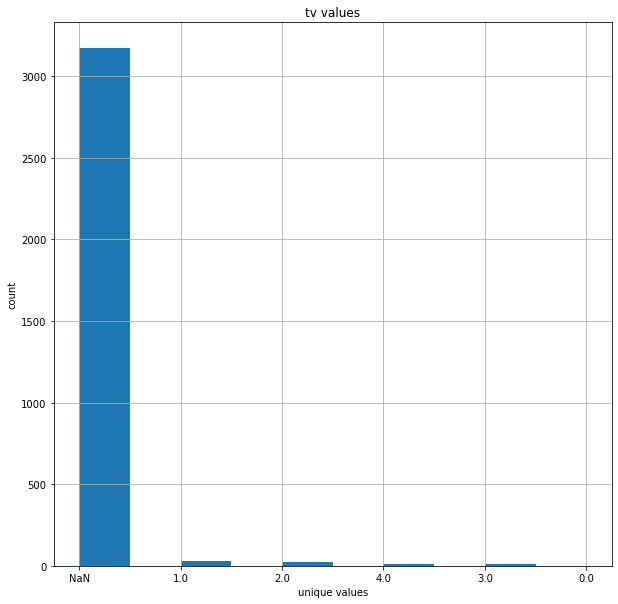

In [338]:
# plotting a histogram for each of the columns in the dataset
for column in df_info_all_meters.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_all_meters[column].replace(np.nan,"NaN").apply(str)
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/{column}_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/{column}_hist.png")
        
    plt.close(fig)

### Calculating percentage of missing values for each column

In [339]:
# Calculating percentage of missing values
#stores index of columns to keep: defaults all to true and will check which to make false
columns = np.full((df_info_all_meters.shape[1],), True, dtype=bool)

# getting the count of each object type in each column
for i in range(0,len(df_info_all_meters.columns)):
    column =df_info_all_meters.columns[i]
    #calculating the percentage of missing values
    percent_missing = df_info_all_meters[column].isnull().sum() * 100 / len(df_info_all_meters)
    print(column+" contains missing values: "+str(df_info_all_meters[column].isna().values.any()))
    print(column+" is missing: "+str(round(percent_missing,2))+"%")
    
    #if the percentage of missing values is greater than 50% mark them to be removed
    if(percent_missing>=50):
        print("Marked ",column,"for removal due to it having more than 50% missing values")
        columns[i] = False
    else:
        print("Not marked ",column,"for removal due to it not having more than 50% missing values")
    print()

meter_id contains missing values: False
meter_id is missing: 0.0%
Not marked  meter_id for removal due to it not having more than 50% missing values

dwelling_type contains missing values: True
dwelling_type is missing: 47.6%
Not marked  dwelling_type for removal due to it not having more than 50% missing values

num_occupants contains missing values: True
num_occupants is missing: 97.72%
Marked  num_occupants for removal due to it having more than 50% missing values

num_bedrooms contains missing values: True
num_bedrooms is missing: 42.76%
Not marked  num_bedrooms for removal due to it not having more than 50% missing values

heating_fuel contains missing values: True
heating_fuel is missing: 97.6%
Marked  heating_fuel for removal due to it having more than 50% missing values

hot_water_fuel contains missing values: True
hot_water_fuel is missing: 97.66%
Marked  hot_water_fuel for removal due to it having more than 50% missing values

boiler_age contains missing values: True
boiler_a

#### Meaning of findings;
* As the histograms and calculations show: there is a massive amount of missing values
* Marked all columns with > 50% missing values for removal
    * as if more than half of the values are missing it is likely what we do impute won't be accurate
* Need to decide what to do with the the remaining 2 as they have 40% missing values: is this good enough?
    * Will likely require experimentation:
        * So will run one model which only uses energy
        * And one that uses addInfo after the missing values have been imputed

## Removing the columns with greater than 50% missing values

In [340]:
# Removing the columns marked for removal
selected_columns = df_info_all_meters.columns[columns]
df_info_all_meters = df_info_all_meters[selected_columns]

In [341]:
# inspecting the current state of df_info_all_meters
df_info_all_meters

,meter_id,dwelling_type,num_bedrooms
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,semi_detached_house,3.0
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,terraced_house,2.0
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,semi_detached_house,NaN
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,detached_house,4.0
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,NaN,NaN
...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,NaN,NaN
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,NaN,NaN
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,NaN,NaN
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,NaN,NaN


## Imputing the missing values
* May be worth experimenting with different imputation methods
* But for now just going with KNN

### Preparing dataframe for use by KNNImputer
### Adding information on the energy time series data that may be useful for imputing the missing addInfo values
Experimenting with different combinations 9think it may have been too many when I originally used 4 different energy ones and it got weighted too highly skewing it due to the multi collinearity problems

In [342]:
# Calculating the total, mean, max, and min energy usage only using KNOWN values (not including the interpolated ones)
df_energy_info = pd.DataFrame(columns=["meter_id",
                                       "mean_energy_usage",
                                       #"max_energy_usage",
                                       #"min_energy_usage",
                                       "total_energy_usage"
                                      ])
df_energy_info["meter_id"]=df_energy_daily["meter_id"].values
df_energy_info["mean_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].mean(axis=1).round(3)
#df_energy_info["max_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].max(axis=1).round(3)
#df_energy_info["min_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].min(axis=1).round(3)
df_energy_info["total_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].sum(axis=1).round(3)

In [343]:
df_energy_info#.loc[df_energy_means["meter_id"]=="0xa62b9f23553ff183f61e2bf943aab3d5983d02d7"]

,meter_id,mean_energy_usage,total_energy_usage
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,4.413,101.490
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,18.888,434.419
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,12.482,287.095
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,18.237,419.449
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,32.586,749.479
...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,5.200,1747.050
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,5.930,1867.938
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,5.755,1939.346
3246,0x47218b46abb2fcaade487a211911406dc6e13730,15.129,5113.478


In [344]:
#add the total, mean, max, and min to the df for use with knn imputation
df_info_knn = df_info_all_meters
df_info_knn = df_info_knn.merge(df_energy_info[["meter_id",
                                                "mean_energy_usage",
                                                #"max_energy_usage",
                                                #"min_energy_usage", 
                                                "total_energy_usage"
                                               ]], on="meter_id",how="left")
df_info_knn#.loc[df_info_knn2["meter_id"]=="0xa62b9f23553ff183f61e2bf943aab3d5983d02d7"]

,meter_id,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,semi_detached_house,3.0,7.374,567.798
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,terraced_house,2.0,5.536,1062.901
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,semi_detached_house,NaN,5.729,1105.627
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,detached_house,4.0,10.597,551.037
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,NaN,NaN,14.302,743.699
...,...,...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,NaN,NaN,21.294,7218.808
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,NaN,NaN,17.709,5932.525
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,NaN,NaN,11.912,4014.327
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,NaN,NaN,5.200,1747.050


### Dropping meter_id, encoding and normalizing data so it is suitable for KNN Imputation
#### Dropping meter_id

In [345]:
#dropping the id column so it doesn't negatively influence the knn algorithm
meter_id = df_info_knn["meter_id"]
df_info_knn = df_info_knn.drop(["meter_id"], axis=1)

In [346]:
#inspecting the df without the id column
df_info_knn

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,semi_detached_house,3.0,7.374,567.798
1,terraced_house,2.0,5.536,1062.901
2,semi_detached_house,NaN,5.729,1105.627
3,detached_house,4.0,10.597,551.037
4,NaN,NaN,14.302,743.699
...,...,...,...,...
3243,NaN,NaN,21.294,7218.808
3244,NaN,NaN,17.709,5932.525
3245,NaN,NaN,11.912,4014.327
3246,NaN,NaN,5.200,1747.050


#### Encoding the categorical values ready for knn

In [347]:
df_info_knn_encoded = df_info_knn
df_info_knn_encoded["dwelling_type"]=df_info_knn_encoded["dwelling_type"].replace("flat",0).replace("terraced_house",1).replace("semi_detached_house",2).replace("detached_house",3).replace("bungalow",4)

"""df_dwelling_types_encoded = df_info_knn["dwelling_type"]
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("flat",0)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("terraced_house",1)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("semi_detached_house",2)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("detached_house",3)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("bungalow",4)"""

'df_dwelling_types_encoded = df_info_knn["dwelling_type"]\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("flat",0)\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("terraced_house",1)\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("semi_detached_house",2)\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("detached_house",3)\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("bungalow",4)'

In [348]:
df_info_knn_encoded

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,2.0,3.0,7.374,567.798
1,1.0,2.0,5.536,1062.901
2,2.0,NaN,5.729,1105.627
3,3.0,4.0,10.597,551.037
4,NaN,NaN,14.302,743.699
...,...,...,...,...
3243,NaN,NaN,21.294,7218.808
3244,NaN,NaN,17.709,5932.525
3245,NaN,NaN,11.912,4014.327
3246,NaN,NaN,5.200,1747.050


#### Normalizing the data

In [349]:
# Normalizing the data as KNN is done via a distance measure and we don't want to skew it
scaler = MinMaxScaler()
df_info_knn_normalized = pd.DataFrame(scaler.fit_transform(df_info_knn_encoded), columns = df_info_knn_encoded.columns)

# inspecting new state of the dataframe after normalisation
df_info_knn_normalized

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,0.50,0.50,0.102095,0.034547
1,0.25,0.25,0.076361,0.064671
2,0.50,NaN,0.079063,0.067271
3,0.75,0.75,0.147219,0.033527
4,NaN,NaN,0.199093,0.045250
...,...,...,...,...
3243,NaN,NaN,0.296987,0.439221
3244,NaN,NaN,0.246794,0.360959
3245,NaN,NaN,0.165631,0.244248
3246,NaN,NaN,0.071657,0.106298


### Now data is prepared, using KNN to impute the missing values
* Experiment with different numbers for nearest neighbours

In [350]:
# now using KNN to impute the missing values
imputer = KNNImputer(n_neighbors=5)
df_info_knn_imputed = pd.DataFrame(imputer.fit_transform(df_info_knn_normalized),columns = df_info_knn_normalized.columns)

# inspecting new state of the dataset now it no longer has missing values
df_info_knn_imputed

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,0.50,0.50,0.102095,0.034547
1,0.25,0.25,0.076361,0.064671
2,0.50,0.45,0.079063,0.067271
3,0.75,0.75,0.147219,0.033527
4,0.65,0.70,0.199093,0.045250
...,...,...,...,...
3243,0.40,0.65,0.296987,0.439221
3244,0.60,0.55,0.246794,0.360959
3245,0.75,0.55,0.165631,0.244248
3246,0.60,0.45,0.071657,0.106298


In [351]:
# checking it no longer has missing values
df_info_knn_imputed.isna().any()

dwelling_type         False
num_bedrooms          False
mean_energy_usage     False
total_energy_usage    False
dtype: bool

In [352]:
# looking at sum of missing values
df_info_knn_imputed.isna().sum()

dwelling_type         0
num_bedrooms          0
mean_energy_usage     0
total_energy_usage    0
dtype: int64

#### Turning these imputed values to usable values

In [353]:
#Unnormalsing the data
df_info_knn_imputed.columns[1:] #ignoring meter id as that wasn't normalized
df_info_knn_finished = pd.DataFrame(scaler.inverse_transform(df_info_knn_imputed), columns = df_info_knn_imputed.columns) # reversing the normalization

In [354]:
# viewing the unormalised data
df_info_knn_finished

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,2.0,3.0,7.374,567.798
1,1.0,2.0,5.536,1062.901
2,2.0,2.8,5.729,1105.627
3,3.0,4.0,10.597,551.037
4,2.6,3.8,14.302,743.699
...,...,...,...,...
3243,1.6,3.6,21.294,7218.808
3244,2.4,3.2,17.709,5932.525
3245,3.0,3.2,11.912,4014.327
3246,2.4,2.8,5.200,1747.050


In [355]:
#rounding bedrooms to their final value
num_bedrooms=df_info_knn_finished["num_bedrooms"].round() 

In [356]:
#rounding dwelling type to a real value
df_dwellings=df_info_knn_finished["dwelling_type"].round() 
#reverting the encoding
df_dwellings=df_dwellings.replace(0, "flat").replace(1, "terraced_house").replace(2, "semi_detached_house").replace(3, "detached_house").replace(4, "bungalow")


In [357]:
#concatenating the meter_id, number of bedrooms, and dwellings columns
df_info_knn_finished = pd.concat([meter_id, num_bedrooms, df_dwellings], axis=1)

In [358]:
#inspecting the final configuration of the knn imputed values
df_info_knn_finished

,meter_id,num_bedrooms,dwelling_type
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,3.0,semi_detached_house
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,2.0,terraced_house
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,3.0,semi_detached_house
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,4.0,detached_house
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,4.0,detached_house
...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,4.0,semi_detached_house
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,3.0,semi_detached_house
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,3.0,detached_house
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,3.0,semi_detached_house


## Checking the unique values are the same as the original set

In [359]:
#looking at the unique values for each column before imputation
print("Unique values before imputation")

print("num_bedrooms unique value count: "+str(df_info_all_meters["num_bedrooms"].nunique()))
print(df_info_all_meters["num_bedrooms"].unique())
print()
print("dwelling_type unique value count: "+str(df_info_all_meters["dwelling_type"].nunique()))
print(df_info_all_meters["dwelling_type"].unique())
print()

Unique values before imputation
num_bedrooms unique value count: 5
[ 3.  2. nan  4.  5.  1.]

dwelling_type unique value count: 5
['semi_detached_house' 'terraced_house' 'detached_house' nan 'bungalow'
 'flat']



In [360]:
#looking at the unique values for each column before imputation
print("Unique values after imputation\n")

print("num_bedrooms unique value count: "+str(df_info_knn_finished["num_bedrooms"].nunique()))
print(df_info_knn_finished["num_bedrooms"].unique())
print()
print("dwelling_type unique value count: "+str(df_info_knn_finished["dwelling_type"].nunique()))
print(df_info_knn_finished["dwelling_type"].unique())
print()

Unique values after imputation

num_bedrooms unique value count: 5
[3. 2. 4. 5. 1.]

dwelling_type unique value count: 5
['semi_detached_house' 'terraced_house' 'detached_house' 'bungalow' 'flat']



## Comparing the distribution of unique values that were distributed to the original

In [361]:
#looking at percentage distribution of values before imputation
print("Distribution of unique values before imputation")
print()

num_bedrooms_percentages = df_info_all_meters['num_bedrooms'].value_counts(normalize=True) * 100
print("num_bedrooms percentages")
print(num_bedrooms_percentages)
print()
print("num_bedrooms totals")
print(df_info_all_meters['num_bedrooms'].value_counts())
print()
print()

dwelling_type_percentages = df_info_all_meters['dwelling_type'].value_counts(normalize=True) * 100
print("dwelling_type percentages")
print(dwelling_type_percentages)
print()
print("dwelling_type totals")
print(df_info_all_meters['dwelling_type'].value_counts())

Distribution of unique values before imputation

num_bedrooms percentages
3.0    62.506724
4.0    18.396988
2.0    14.039806
5.0     4.249597
1.0     0.806885
Name: num_bedrooms, dtype: float64

num_bedrooms totals
3.0    1162
4.0     342
2.0     261
5.0      79
1.0      15
Name: num_bedrooms, dtype: int64


dwelling_type percentages
semi_detached_house    38.719154
detached_house         21.974148
terraced_house         18.331375
bungalow               17.215041
flat                    3.760282
Name: dwelling_type, dtype: float64

dwelling_type totals
semi_detached_house    659
detached_house         374
terraced_house         312
bungalow               293
flat                    64
Name: dwelling_type, dtype: int64


In [362]:
#looking at percentage distribution of values after imputation
print("Distribution of unique values before imputation")
print()

num_bedrooms_percentages = df_info_knn_finished['num_bedrooms'].value_counts(normalize=True) * 100
print("num_bedrooms percentages")
print(num_bedrooms_percentages)
print()
print("num_bedrooms totals")
print(df_info_knn_finished['num_bedrooms'].value_counts())
print()
print()

dwelling_type_percentages = df_info_knn_finished['dwelling_type'].value_counts(normalize=True) * 100
print("dwelling_type percentages")
print(dwelling_type_percentages)
print()
print("dwelling_type totals")
print(df_info_knn_finished['dwelling_type'].value_counts())
print()

Distribution of unique values before imputation

num_bedrooms percentages
3.0    70.966749
4.0    16.071429
2.0    10.067734
5.0     2.432266
1.0     0.461823
Name: num_bedrooms, dtype: float64

num_bedrooms totals
3.0    2305
4.0     522
2.0     327
5.0      79
1.0      15
Name: num_bedrooms, dtype: int64


dwelling_type percentages
semi_detached_house    51.139163
detached_house         25.738916
terraced_house         11.730296
bungalow                9.421182
flat                    1.970443
Name: dwelling_type, dtype: float64

dwelling_type totals
semi_detached_house    1661
detached_house          836
terraced_house          381
bungalow                306
flat                     64
Name: dwelling_type, dtype: int64



##### Conclusions:
* Hasn't imputed any meters to be a flat
* Hasn't imputed any meters to have 1 or 5 bedrooms
* Has essentially increased the % divide
    * Higher % represented classes were more likely to be picked
    * Whilst lower % represented classes were less likely to be picked 
* Expected behaviour but is this useful and has it imputed correctly?
* As mentioned already will experiment and see if using these meters or not improves performance more
    * From this we can infer if this was effective or not

## Plotting hists of the imputed addInfo
plotting hists of the imputed addInfo columns before and after imputation to compare their patterns

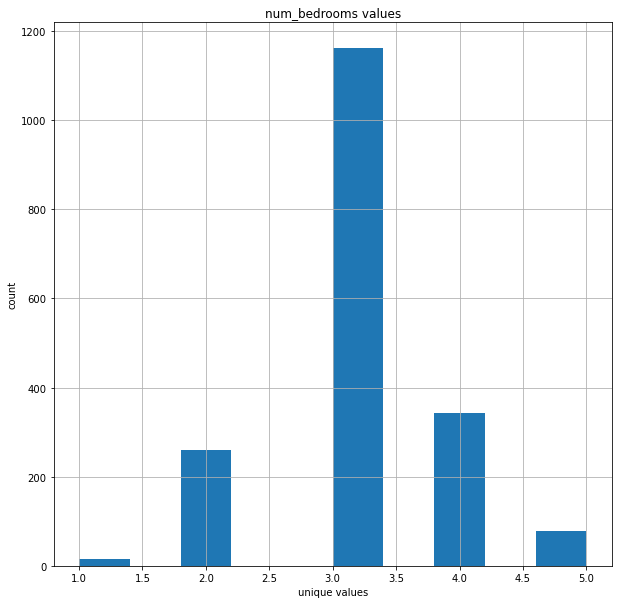

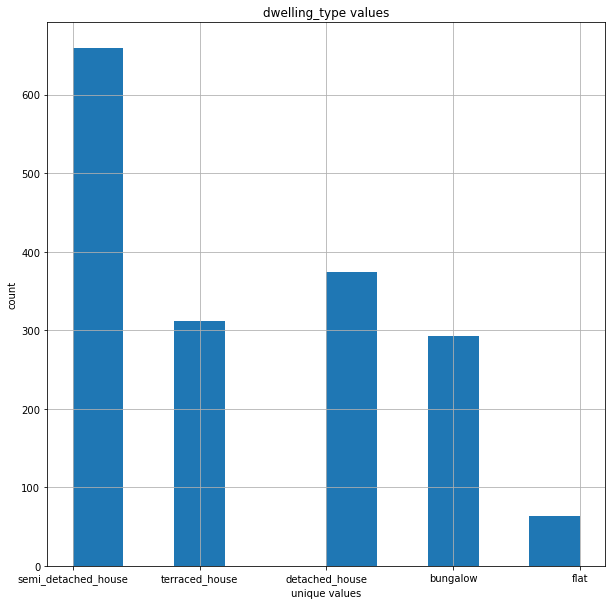

In [363]:
# plotting a histogram for each of the imputed columns in the dataset before imputation
for column in df_info_knn_finished.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_all_meters[column]
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/Pre-Imputation/{column}_preimp_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/Pre-Imputation/{column}_preimp_hist.png")
        
    plt.close(fig)

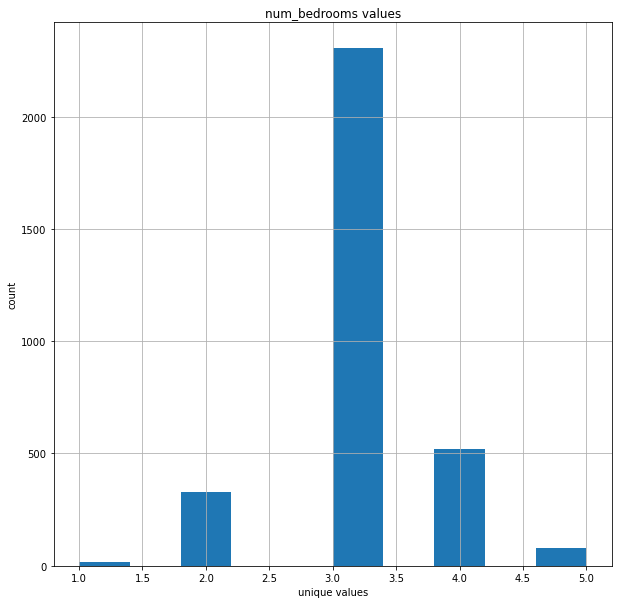

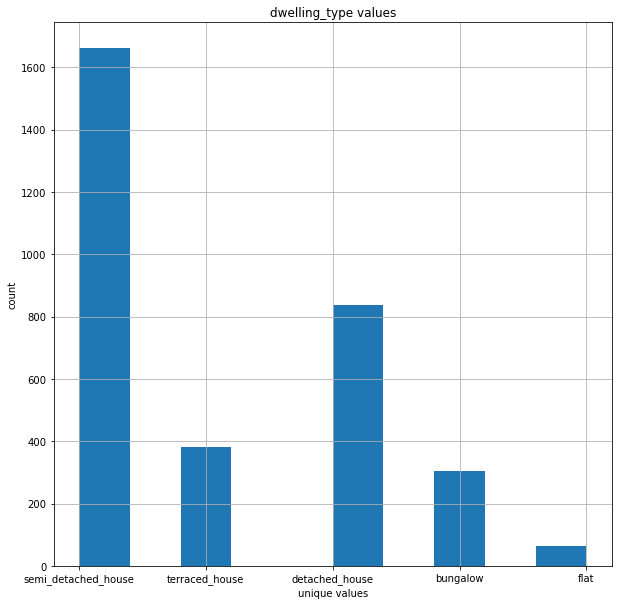

In [364]:
# plotting a histogram for each of the columns in the dataset after imputation
for column in df_info_knn_finished.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_knn_finished[column]
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/Imputed/{column}_imp_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/Imputed/{column}_imp_hist.png")
        
    plt.close(fig)

## OneHot Encoding Ready for the RNN to make use of

In [302]:
#encoding the categorical values via one hot encoding
cat_variables = df_info_knn_finished[df_info_knn_finished.loc[:,df_info_knn_finished.columns!="meter_id"].select_dtypes(include=['object']).columns] # getting the categorical columns (just 'dwelling_type')
cat_dummies = pd.get_dummies(cat_variables, drop_first=True, dummy_na=True) # getting dummies, including a separate one for na

#setting nan rows and droppoing nan column
cat_dummies.loc[cat_dummies.dwelling_type_nan==1, ["dwelling_type_detached_house","dwelling_type_flat","dwelling_type_semi_detached_house","dwelling_type_terraced_house"]]=np.nan
cat_dummies=cat_dummies.drop("dwelling_type_nan",axis=1)
cat_dummies

,dwelling_type_detached_house,dwelling_type_flat,dwelling_type_semi_detached_house,dwelling_type_terraced_house
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
3243,0.0,0.0,1.0,0.0
3244,0.0,0.0,1.0,0.0
3245,1.0,0.0,0.0,0.0
3246,0.0,0.0,1.0,0.0


In [303]:
# dropping those original columns then adding the dummy values
df_info_knn_finished = df_info_knn_finished.drop(df_info_knn_finished.loc[:,df_info_knn_finished.columns!="meter_id"].select_dtypes(include=['object']).columns, axis=1)
df_info_knn_finished = pd.concat([df_info_knn_finished, cat_dummies], axis=1)
# inspecting new state of the dataframe with the dummy variables
df_info_knn_finished

,meter_id,num_bedrooms,dwelling_type_detached_house,dwelling_type_flat,dwelling_type_semi_detached_house,dwelling_type_terraced_house
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,3.0,0.0,0.0,1.0,0.0
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,2.0,0.0,0.0,0.0,1.0
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,3.0,0.0,0.0,1.0,0.0
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,4.0,1.0,0.0,0.0,0.0
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,4.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,4.0,0.0,0.0,1.0,0.0
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,3.0,0.0,0.0,1.0,0.0
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,3.0,1.0,0.0,0.0,0.0
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,3.0,0.0,0.0,1.0,0.0


## Generating correlation plot of the features to make sure there is minimal redundancy

In [304]:
#generating the correlation matrix
corr_info = df_info_knn_finished.corr()

<AxesSubplot:>

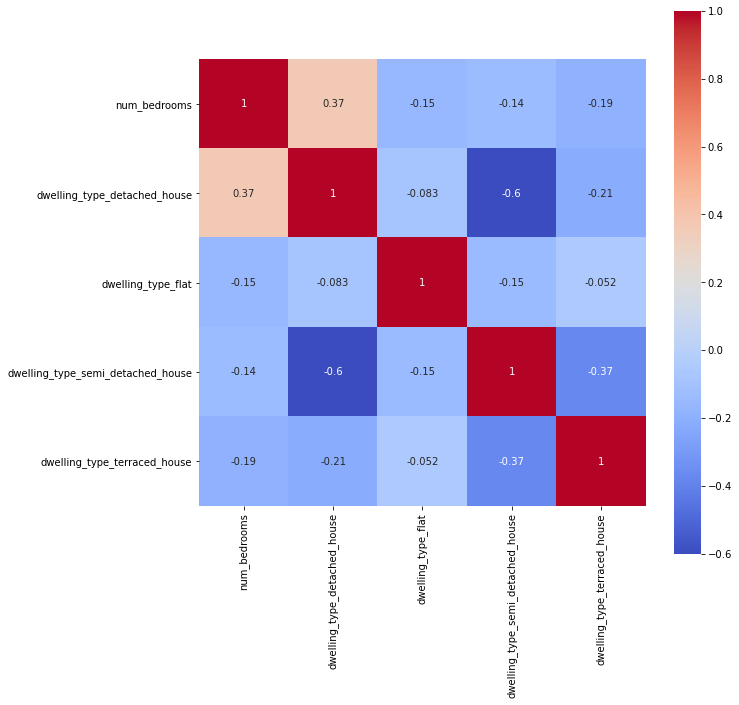

In [305]:
#generating the correlation heat map
plt.figure(figsize=(10, 10))
sns.heatmap(corr_info, cmap="coolwarm", annot=True, square=True)

In [306]:
# for each feature on the x axis
for i in range(corr_info.shape[0]):
    # for each feature after i
    for j in range(i+1, corr_info.shape[0]):
        #check if their correlation is above a threshold % (50%)
        if abs(corr_info.iloc[i,j]) >= 0.5:
            print("\nConsider ",corr_info.columns[j]," for removal as it has a high correlation with ",corr_info.columns[i]," of",round(corr_info.iloc[i,j],2),"\n")
            #set column j to be removed 
            if columns[j]:
                columns[j+1] = False #+1 for meter id
        else: 
            print("Keeping ",corr_info.columns[i]," and ",corr_info.columns[j]," have a correlation of ", round(corr_info.iloc[i,j],2))

Keeping  num_bedrooms  and  dwelling_type_detached_house  have a correlation of  0.37
Keeping  num_bedrooms  and  dwelling_type_flat  have a correlation of  -0.15
Keeping  num_bedrooms  and  dwelling_type_semi_detached_house  have a correlation of  -0.14
Keeping  num_bedrooms  and  dwelling_type_terraced_house  have a correlation of  -0.19
Keeping  dwelling_type_detached_house  and  dwelling_type_flat  have a correlation of  -0.08

Consider  dwelling_type_semi_detached_house  for removal as it has a high correlation with  dwelling_type_detached_house  of -0.6 

Keeping  dwelling_type_detached_house  and  dwelling_type_terraced_house  have a correlation of  -0.21
Keeping  dwelling_type_flat  and  dwelling_type_semi_detached_house  have a correlation of  -0.15
Keeping  dwelling_type_flat  and  dwelling_type_terraced_house  have a correlation of  -0.05
Keeping  dwelling_type_semi_detached_house  and  dwelling_type_terraced_house  have a correlation of  -0.37


##### Features don't have a particularly high correlation; no need to remove them based upon this

## Saving the finished AddInfo

In [307]:
if(os.path.exists(f"../Data/Preprocessed_Data/addInfo_knn.pkl")==False):
        df_info_knn_finished.to_pickle(f"../Data/Preprocessed_Data/addInfo_knn.pkl")